
# 1. Wstęp
<img src="https://upload.wikimedia.org/wikipedia/commons/4/41/Iris_versicolor_3.jpg" width="400" style="display:block; margin:auto;" />

**Cel analizy:**  
Analiza danych Iris ma na celu zrozumienie różnic między trzema gatunkami irysów na podstawie cech morfologicznych oraz stworzenie prostego modelu klasyfikacyjnego.  

**Kontekst biznesowy:**  
Tego typu analiza może wspierać procesy automatycznego rozpoznawania gatunków roślin w ogrodnictwie, rolnictwie czy badaniach biologicznych.

**Zawartość raportu:**  
1. Eksploracja danych (EDA)  
2. Wizualizacja kluczowych cech  
3. Analiza ważności cech  
4. Podsumowanie biznesowe i wnioski



# 2. Import bibliotek i wczytanie danych


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Wczytanie danych
data = pd.read_csv("25__iris.csv")

# Zmiana nazw kolumn na polskie
data = data.rename(columns={
    "długość kielicha (sepal length)": "dł. kielicha", 
    "szerokość kielicha (sepal width)": "szer. kielicha", 
    "długość płatka (petal length)": "dł. płatka",
    "szerokość płatka (petal width)": "szer. płatka",
    "klasa (class)": "klasa"
})

data.head()


,dł. kielicha,szer. kielicha,dł. płatka,szer. płatka,klasa
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa



# 3. Eksploracja danych (EDA)


In [2]:

# Informacje ogólne
print(data.info())

# Sprawdzenie braków danych
print("Brakujące wartości:")
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dł. kielicha    150 non-null    float64
 1   szer. kielicha  150 non-null    float64
 2   dł. płatka      150 non-null    float64
 3   szer. płatka    150 non-null    float64
 4   klasa           150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None
Brakujące wartości:
dł. kielicha      0
szer. kielicha    0
dł. płatka        0
szer. płatka      0
klasa             0
dtype: int64


### Krótkie podsumowanie danych

- Liczba rekordów: **150** (brak brakujących wartości).  
- Liczba kolumn: **5** (4 cechy morfologiczne + gatunek `klasa`).   
- Dane są **kompletne** i gotowe do analizy eksploracyjnej (EDA) oraz modelowania.


In [3]:
print(data.describe())

       dł. kielicha  szer. kielicha  dł. płatka  szer. płatka
count    150.000000      150.000000  150.000000    150.000000
mean       5.843333        3.054000    3.758667      1.198667
std        0.828066        0.433594    1.764420      0.763161
min        4.300000        2.000000    1.000000      0.100000
25%        5.100000        2.800000    1.600000      0.300000
50%        5.800000        3.000000    4.350000      1.300000
75%        6.400000        3.300000    5.100000      1.800000
max        7.900000        4.400000    6.900000      2.500000


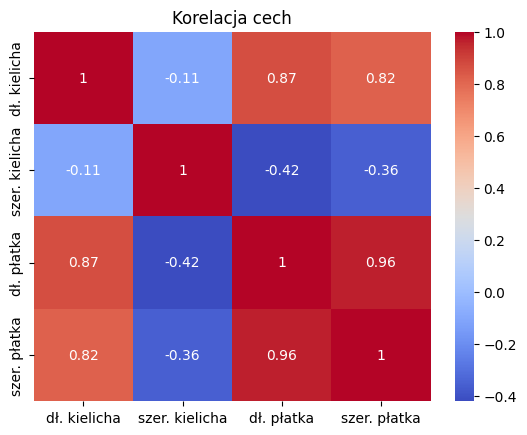

In [4]:
# Heatmapa korelacji
sns.heatmap(data.drop('klasa', axis=1).corr(), annot=True, cmap='coolwarm')
plt.title("Korelacja cech")
plt.show()


## Histogramy rozkładu cech


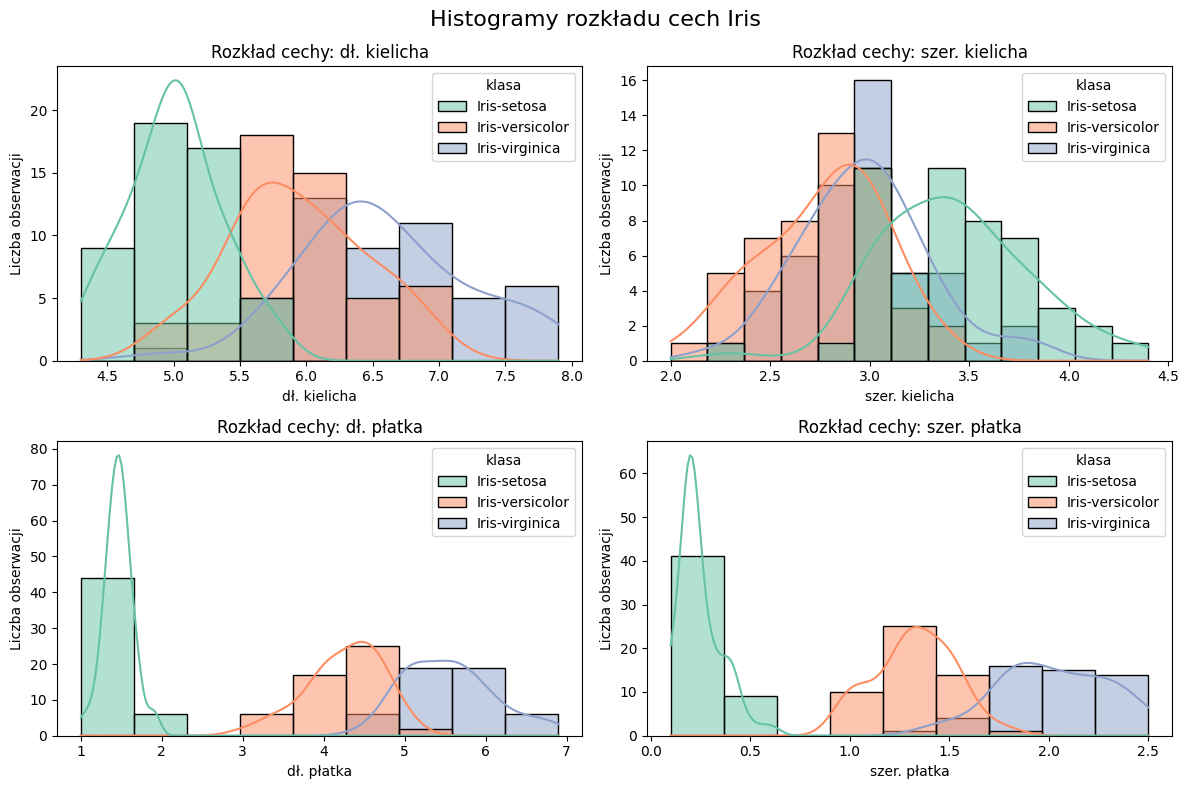

In [5]:
features = ["dł. kielicha", "szer. kielicha", "dł. płatka", "szer. płatka"]

# Tworzenie subplotów w 2 kolumnach
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Histogramy rozkładu cech Iris', fontsize=16)

for i, feature in enumerate(features):
    row = i // 2  # Określa wiersz (0 lub 1)
    col = i % 2   # Określa kolumnę (0 lub 1)
    
    sns.histplot(data=data, x=feature, hue="klasa", kde=True, palette="Set2", ax=axes[row, col])
    axes[row, col].set_title(f"Rozkład cechy: {feature}")
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel("Liczba obserwacji")

plt.tight_layout()
plt.show()


## Boxploty cech


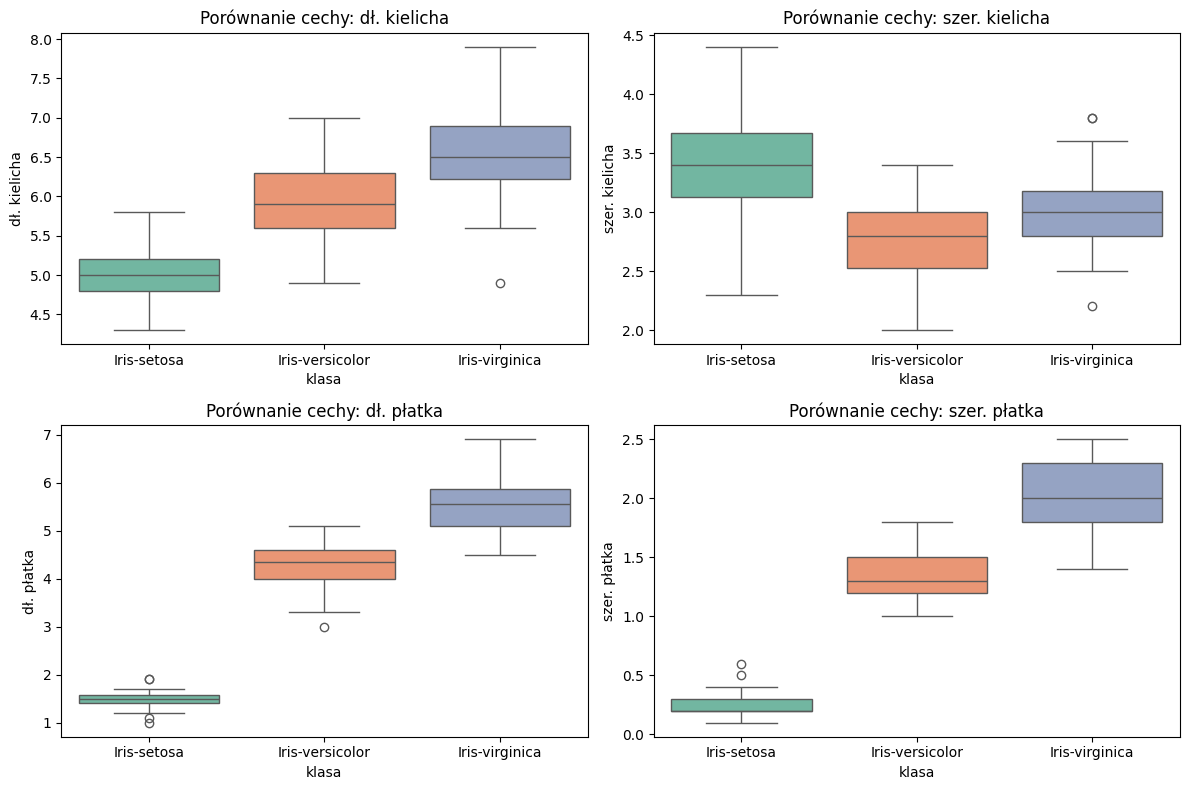

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    sns.boxplot(data=data, x="klasa", y=feature, hue="klasa", palette="Set2", ax=axes[row, col], legend=False)
    axes[row, col].set_title(f"Porównanie cechy: {feature}")
plt.tight_layout()
plt.show()

### Podsumowanie boxplotów

- **Długość i szerokość płatka** wyraźnie rozróżniają gatunki – Setosa ma najkrótsze i najwęższe płatki, Virginica najdłuższe i najszersze.  
- **Długość kielicha** częściowo rozdziela gatunki – Setosa jest najkrótsza, Virginica najdłuższa, ale Versicolor jest pośredni.  
- **Szerokość kielicha** ma największe nakładanie się wartości między gatunkami – najmniej przydatna do klasyfikacji.  
- Obecność **outlierów** (kółka) pokazuje pojedyncze nietypowe kwiaty w każdej grupie.



## Statystyki grupowane wg gatunku


In [7]:
stats_by_species = data.groupby("klasa").agg(["mean", "std"]).round(2)

styled_table = stats_by_species.style\
    .set_caption("Średnie i odchylenia standardowe cech dla gatunków Iris")\
    .background_gradient(axis=0, cmap="YlOrRd", vmin=0)\
    .set_table_styles([
        {
            'selector': 'caption',
            'props': [
                ('color', '#2c3e50'),
                ('font-size', '18px'),
                ('font-weight', 'bold'),
                ('text-align', 'center'),
                ('margin-bottom', '10px'),
                ('font-family', 'Arial, sans-serif')
            ]
        },
        {
            'selector': 'th',
            'props': [
                ('background-color', '#34495e'),
                ('color', 'white'),
                ('font-weight', 'bold'),
                ('text-align', 'center'),
                ('padding', '8px'),
                ('border', '1px solid #2c3e50')
            ]
        },
        {
            'selector': 'td',
            'props': [
                ('text-align', 'center'),
                ('padding', '6px'),
                ('border', '1px solid #bdc3c7'),
                ('font-size', '14px')
            ]
        }
    ])\
    .format(precision=2)\
    .highlight_max(axis=0, color='#e74c3c')\
    .highlight_min(axis=0, color='#27ae60')

styled_table


## Interpretacja tabeli statystyk

### Co przedstawia tabela
- Średnie wartości i odchylenia standardowe dla każdej cechy morfologicznej.  
- Podział na trzy gatunki irysów (Setosa, Versicolor, Virginica).

### Znaczenie statystyk
- **Średnia (mean):** typowa wartość cechy dla danego gatunku.  
- **Odchylenie standardowe (std):** miara zmienności – im większe, tym bardziej rozproszone wartości.

### System kolorowania
- 🔴 **Czerwone komórki** – najwyższe wartości w kolumnie.  
- 🟠 **Gradient żółto‑pomarańczowy** – wartości pośrednie (średnie).  
- 🟢 **Zielone komórki** – najniższe wartości w kolumnie.

### Jak interpretować
- **Większe odchylenia = większa różnorodność** w obrębie gatunku.  
- **Porównanie średnich** pozwala wskazać, które cechy najlepiej rozróżniają gatunki (np. długość płatka dla Virginica jest najwyższa).



# 4. Analiza ważności cech


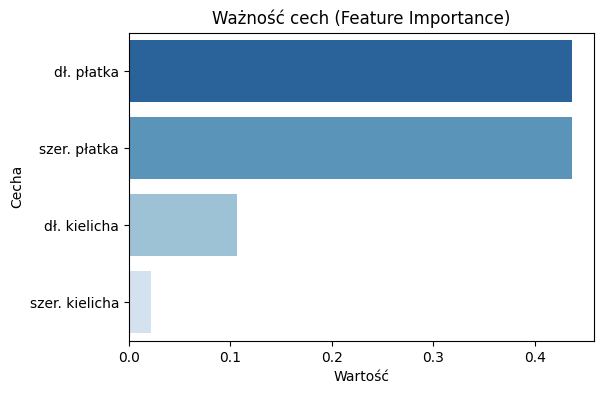

In [8]:
X = data.drop("klasa", axis=1)
y = data["klasa"]

model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X, y)

importances = model_rf.feature_importances_
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=feat_importances.values, y=feat_importances.index, hue=feat_importances.index, palette="Blues_r", legend=False)
plt.title("Ważność cech (Feature Importance)")
plt.xlabel("Wartość")
plt.ylabel("Cecha")
plt.show()



# 5. Podsumowanie

**Kluczowe wnioski:**  
- Cechy płatków najlepiej rozróżniają gatunki.  
- Z analizy wynika iż najważniejsze cechy to  `dł. płatka` oraz `szer. płatka`.  
- Analiza może wspierać procesy automatycznego oznaczania gatunków w zastosowaniach praktycznych.

